# Extra-Pによって出力されたモデルと卒研の4モデルを比較するためのノート

* 問題サイズに対する予測：データ数 4 の平均絶対誤差率よりデータ数 3 の平均絶対誤差率が低い関数
* コア数に対する予測：平均絶対誤差率が0.1%より大きい関数

のプロット・図示を行う。

また、このノートでは最初のポイントが障害となっていると思われるものについては、最初のポイントを除外した上でモデルを生成し、プロットする。

In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb
InteractiveShell.ast_node_interactivity = 'last_expr'

In [2]:
FixedClassDict = {}
for benchmark in benchmarks:
    targetDF = return_ErrorRateFixedClassDF(benchmark=benchmark, FixClass="B", predict_process=256)
    columns = targetDF.columns.tolist()
    # 平均絶対誤差率が0.1より大きいものを抽出
    targetDF = targetDF[targetDF[columns[0]] > 0.1]
    # データが同じことに由来する重複を削除
    targetDF = targetDF[~targetDF.duplicated()]
    targetFunctionNameList = targetDF.index.tolist()
    FixedClassDict[benchmark] = targetFunctionNameList
FixedClassDict

# Extra-Pへの入力ファイルを生成
funcCallNumDict = {}
for benchmarkName in FixedClassDict:
    print(f"-----{benchmarkName}-----")
    if benchmarkName == "bt" or benchmarkName == "sp" :
        _processes = process_onlyBTSP
    else:
        _processes = process_excludeBTSP
    funcCallNumDict[benchmarkName] = {}
    for functionName in FixedClassDict[benchmarkName]:
        funcCallNumDict[benchmarkName][functionName] = returnRawDF(Benchmark = benchmarkName, functionName = functionName, fix="Class", Processes = _processes, FixedBenchmarkClass="B")
#         generateInputFileForExtraP(funcCallNumDict[benchmarkName][functionName], repeated=3, includeLastData = False, fileName = f"tmp_{benchmarkName}_{functionName}.txt")
        print(f"_____\"{functionName}\"_____")

-----bt-----
_____"EXACT_SOLUTION"_____
-----cg-----
_____"MPI_Irecv()"_____
-----ep-----
-----ft-----
_____"CFFTZ"_____
_____"FFTZ2"_____
_____"SET_CLASS"_____
-----is-----
_____"MPI_Irecv()"_____
_____"double_randlc(double_*_double_*)"_____
-----lu-----
_____"BLTS"_____
_____"EXCHANGE_6"_____
-----mg-----
_____"BUBBLE"_____
_____"ZERO3"_____
-----sp-----
_____"EXACT_SOLUTION"_____


> * コア数に対する予測：平均絶対誤差率が0.1%より大きい関数

___________________"ft"_____"CFFTZ"___________________


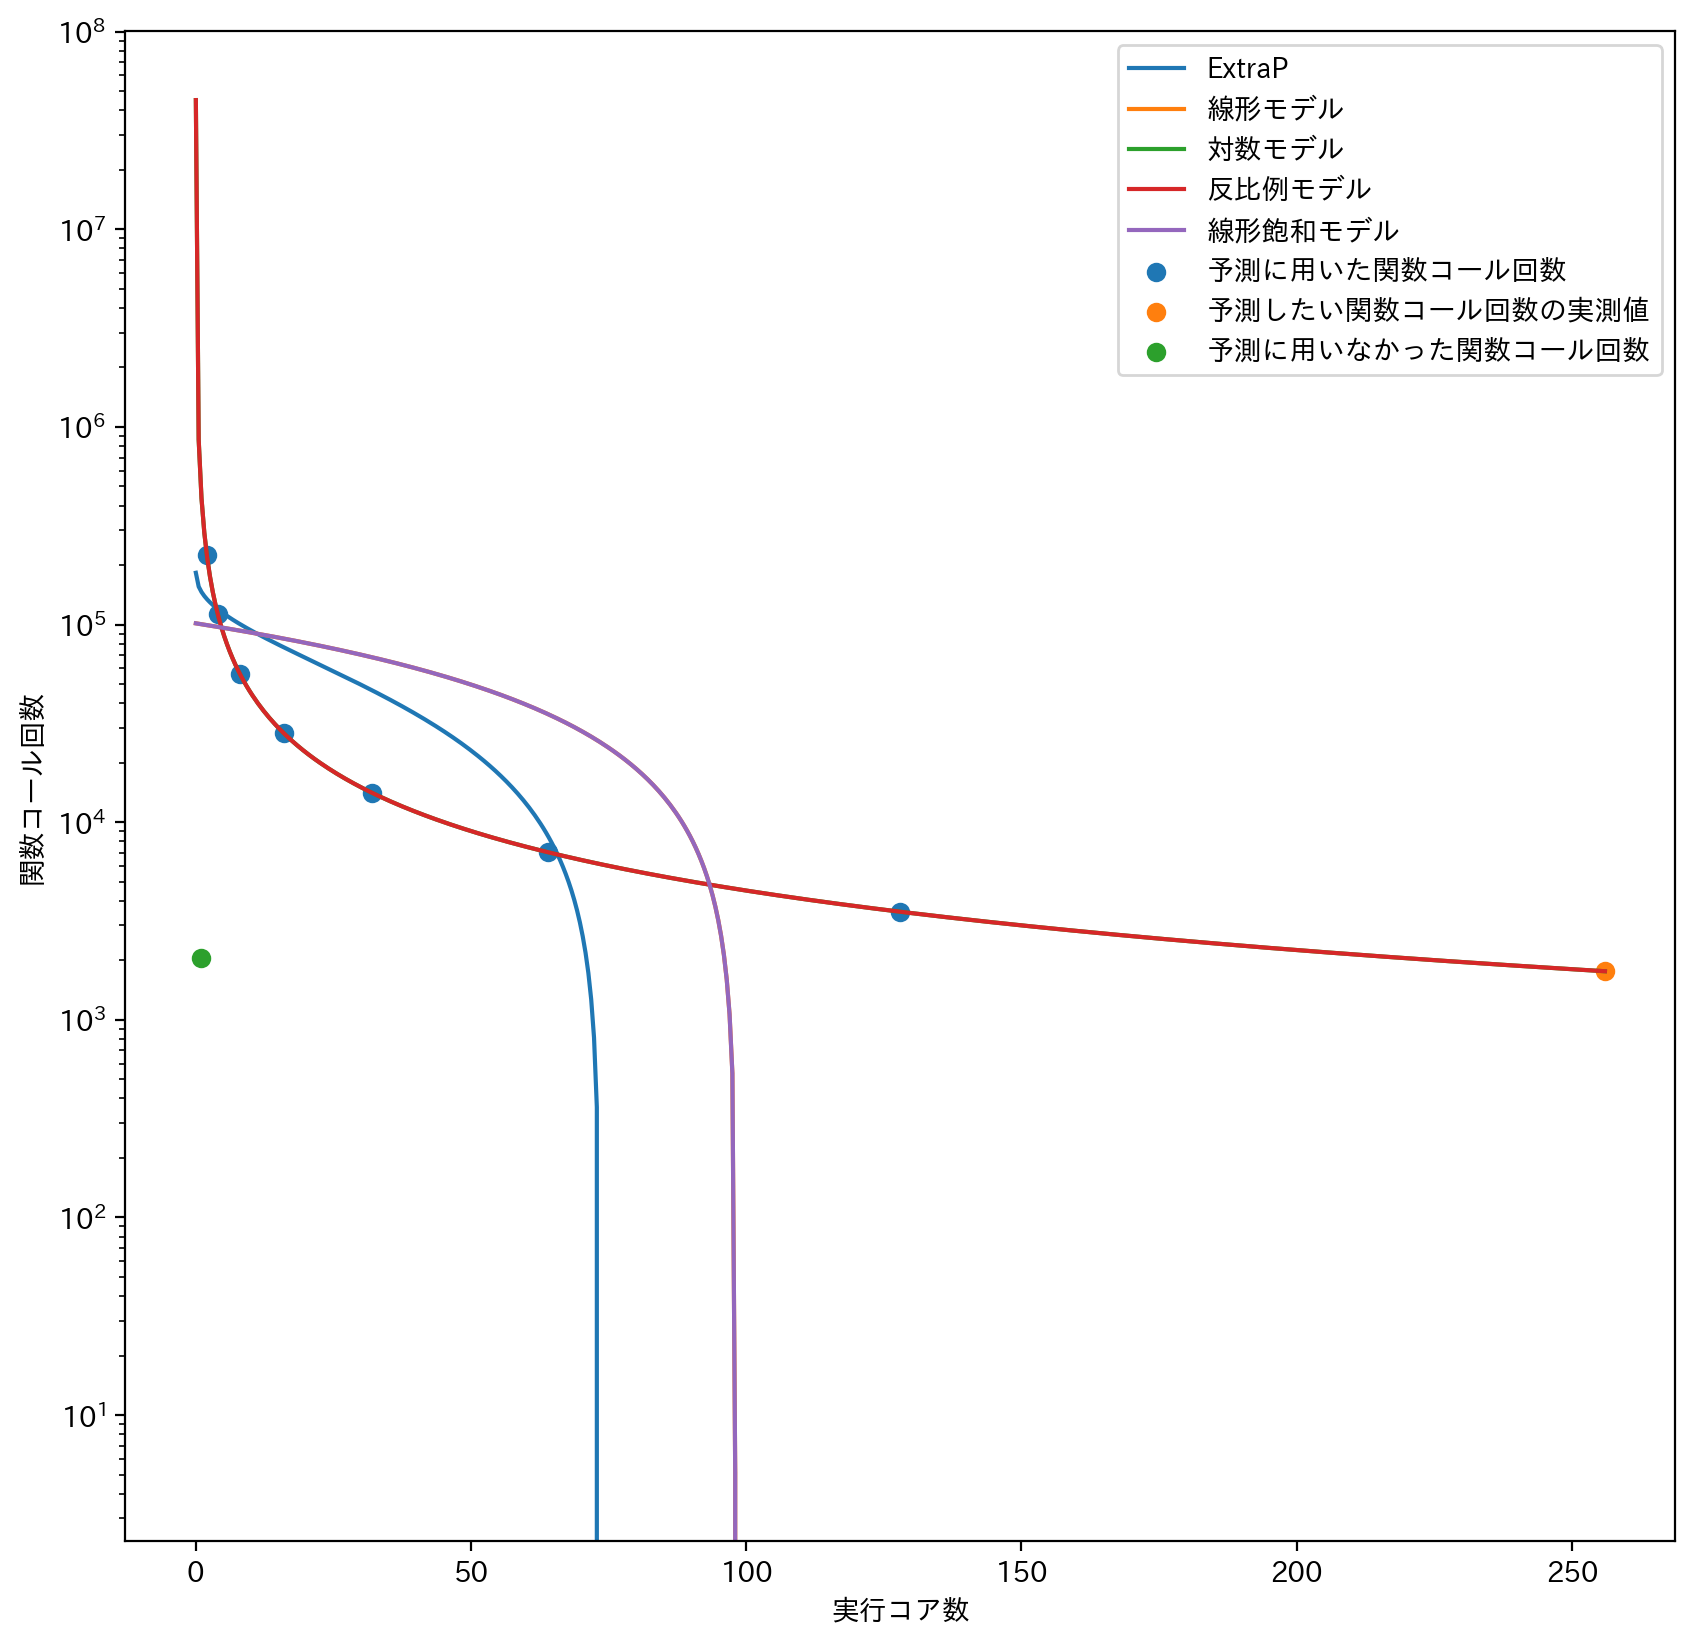

In [3]:
plt.figure(figsize=(10,10),dpi=200)


# ベンチマーク名と関数名の指定
benchmarkName = "ft"
functionName = "CFFTZ"
print(f"___________________\"{benchmarkName}\"_____\"{functionName}\"___________________")

# 実データの取り出し
functionDF = funcCallNumDict[benchmarkName][functionName]
functionDF
raw_x = functionDF.columns.tolist()
raw_y = [functionDF.at[functionName, x] for x in raw_x]

# Extra-P用の入力データの作成
generateInputFileForExtraPfromLists(input_x=raw_x, input_y=raw_y, repeated=3, includeFirstData=False, includeLastData=False, fileName =f"tmp_{benchmarkName}_{functionName}.txt")
raw_x = np.array(raw_x).reshape(-1,1)
raw_y = np.array(raw_y).reshape(-1, 1)
# Extra-PでfixProcessデータを入力して出力したモデルの図示
plot_x = np.linspace(0.01, 256, 500)
# 下記はExtra-Pで出力されたモデル
# 192658.33552658802 + -46041.48912003825 * p^(1/3)
plot_y = []
plot_y = [192658.33552658802 + -46041.48912003825 * x**(1/3) for x in plot_x]
plt.plot(plot_x, plot_y, label="ExtraP")

# 説明変数と目的変数に分割
notTrain_x, train_x, target_x = raw_x[0], raw_x[1:-1], raw_x[-1]
notTrain_y, train_y, target_y = raw_y[0], raw_y[1:-1], raw_y[-1]

plt.scatter(train_x, train_y, marker="o", label="予測に用いた関数コール回数")
plt.scatter(target_x, target_y, marker="o", label="予測したい関数コール回数の実測値")
plt.scatter(notTrain_x, notTrain_y, marker="o", label="予測に用いなかった関数コール回数")

# モデル式をプロットするために変数”plot_x”に対して変換を実施
plot_x = np.array(plot_x).reshape(-1, 1)

# 線形モデル
model_lin = ModelLin(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_lin.calc_lr()
plot_y_lin = model_lin.predict(plot_x)
plt.plot(plot_x, plot_y_lin, label="線形モデル")
# 対数モデル
model_log10 = ModelLog10(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_log10.calc_lr()
plot_y_log10 = model_log10.predict(plot_x)
plt.plot(plot_x, plot_y_log10, label="対数モデル")
# 反比例モデル
model_ip = ModelIP(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_ip.calc_lr()
plot_y_ip = model_ip.predict(plot_x)
plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# 線形飽和モデル
model_branch = ModelBranch(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_branch.calc_lr()
plot_y_branch = model_branch.predict(plot_x)
plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("実行コア数")
# 軸の対数軸化
# plt.xscale('log')
plt.yscale('log')

___________________"ft"_____"FFTZ2"___________________


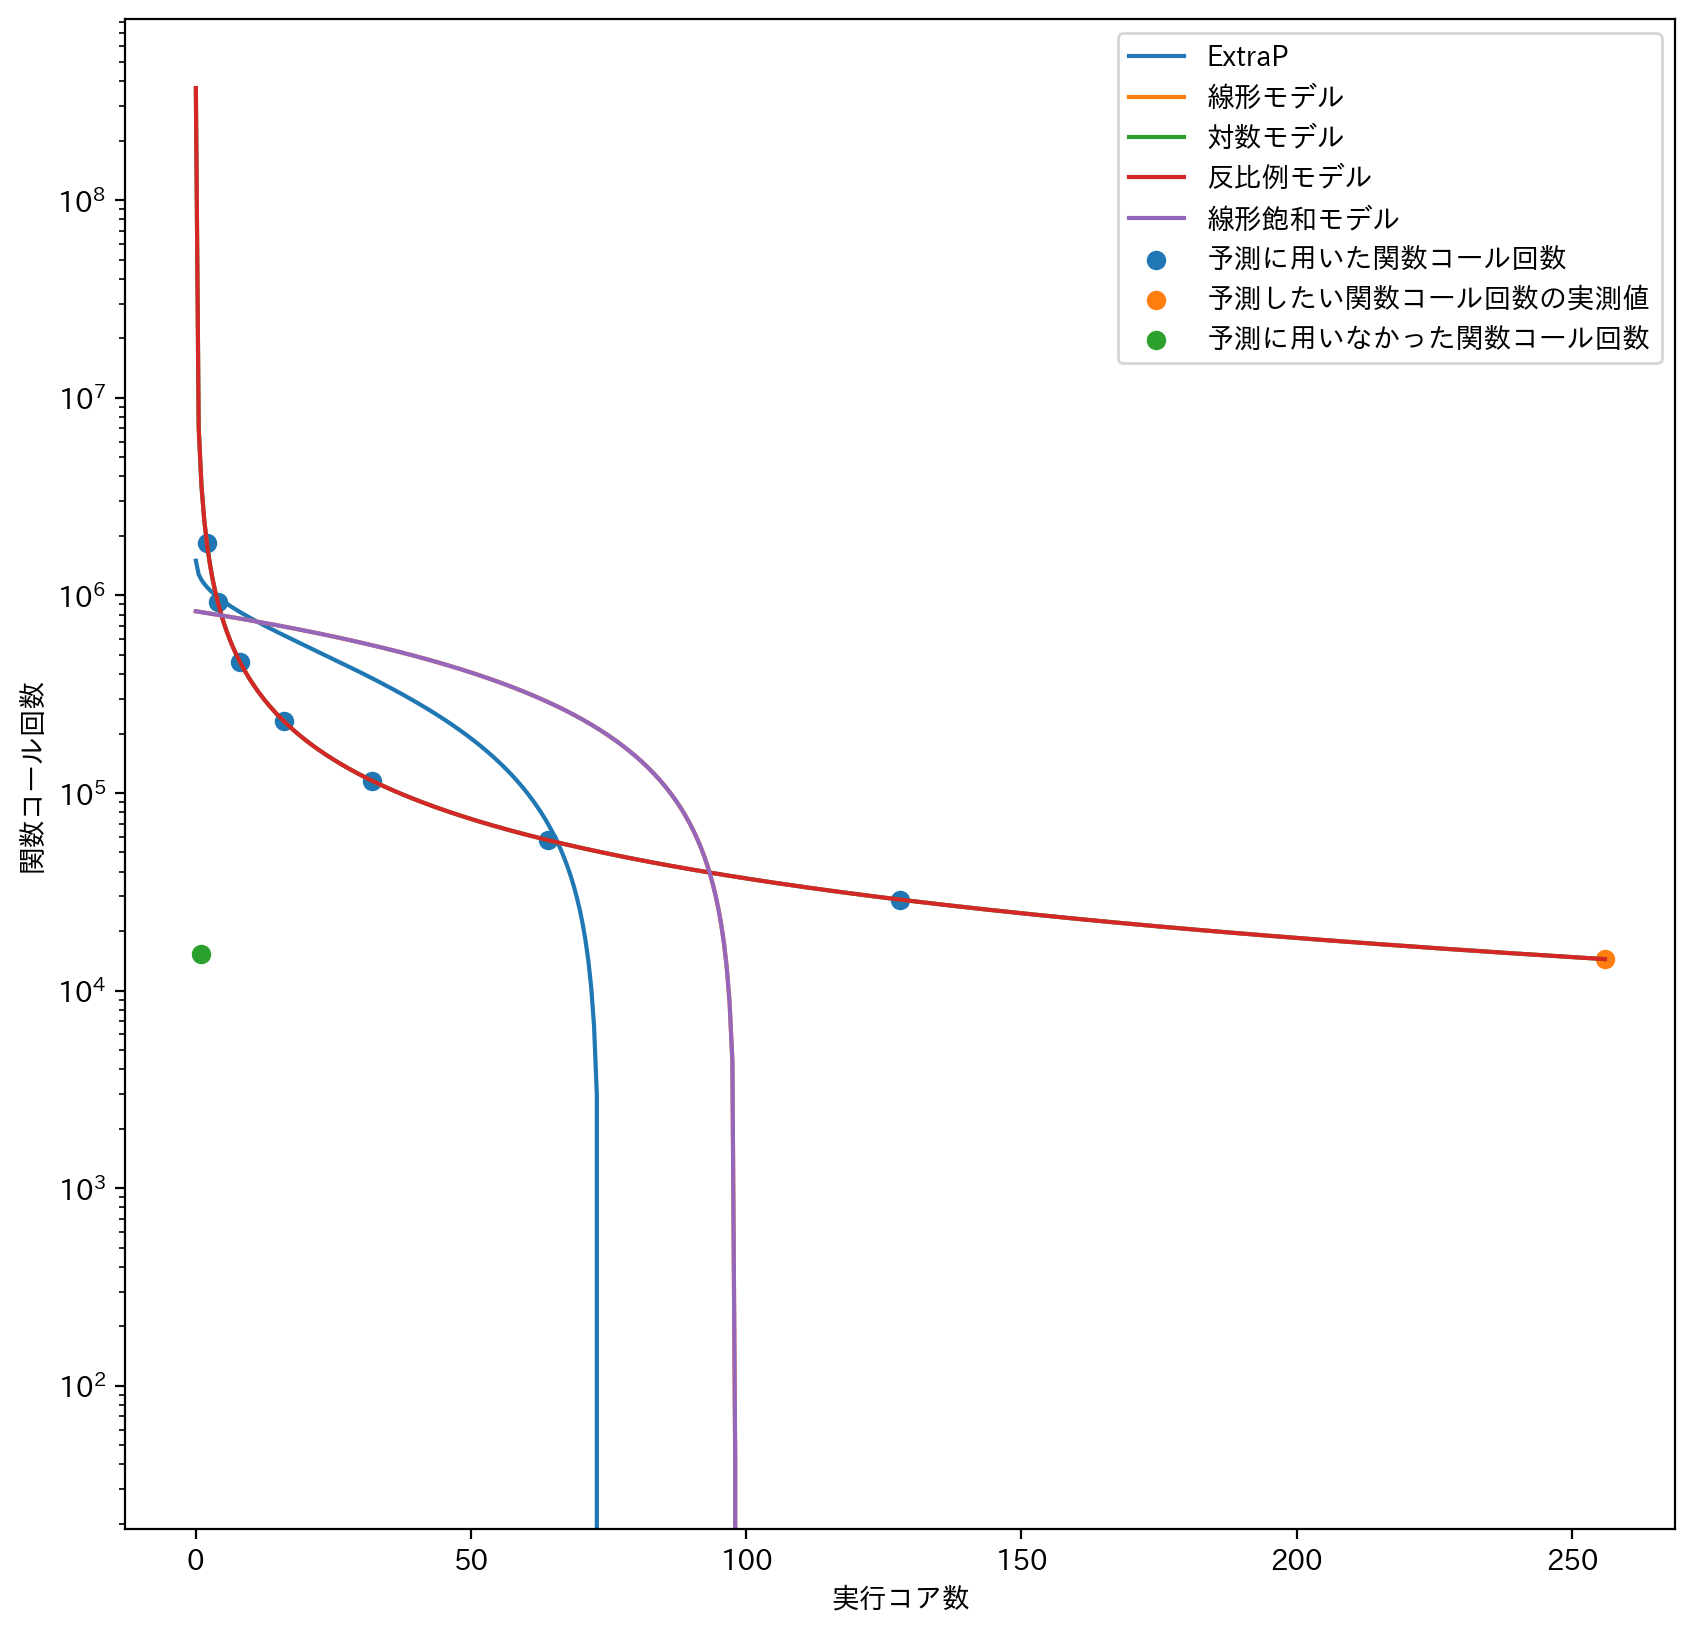

In [4]:
plt.figure(figsize=(10,10),dpi=200)


# ベンチマーク名と関数名の指定
benchmarkName = "ft"
functionName = "FFTZ2"
print(f"___________________\"{benchmarkName}\"_____\"{functionName}\"___________________")

# 実データの取り出し
functionDF = funcCallNumDict[benchmarkName][functionName]
functionDF
raw_x = functionDF.columns.tolist()
raw_y = [functionDF.at[functionName, x] for x in raw_x]

# Extra-P用の入力データの作成
generateInputFileForExtraPfromLists(input_x=raw_x, input_y=raw_y, repeated=3, includeFirstData=False, includeLastData=False, fileName =f"tmp_{benchmarkName}_{functionName}.txt")
raw_x = np.array(raw_x).reshape(-1,1)
raw_y = np.array(raw_y).reshape(-1, 1)
# Extra-PでfixProcessデータを入力して出力したモデルの図示
plot_x = np.linspace(0.01, 256, 500)
# 下記はExtra-Pで出力されたモデル
#  1579800.4646375452 + -377540.76197567827 * p^(1/3)
plot_y = []
plot_y = [ 1579800.4646375452 + -377540.76197567827 * x**(1/3) for x in plot_x]
plt.plot(plot_x, plot_y, label="ExtraP")

# 説明変数と目的変数に分割
notTrain_x, train_x, target_x = raw_x[0], raw_x[1:-1], raw_x[-1]
notTrain_y, train_y, target_y = raw_y[0], raw_y[1:-1], raw_y[-1]

plt.scatter(train_x, train_y, marker="o", label="予測に用いた関数コール回数")
plt.scatter(target_x, target_y, marker="o", label="予測したい関数コール回数の実測値")
plt.scatter(notTrain_x, notTrain_y, marker="o", label="予測に用いなかった関数コール回数")

# モデル式をプロットするために変数”plot_x”に対して変換を実施
plot_x = np.array(plot_x).reshape(-1, 1)

# 線形モデル
model_lin = ModelLin(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_lin.calc_lr()
plot_y_lin = model_lin.predict(plot_x)
plt.plot(plot_x, plot_y_lin, label="線形モデル")
# 対数モデル
model_log10 = ModelLog10(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_log10.calc_lr()
plot_y_log10 = model_log10.predict(plot_x)
plt.plot(plot_x, plot_y_log10, label="対数モデル")
# 反比例モデル
model_ip = ModelIP(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_ip.calc_lr()
plot_y_ip = model_ip.predict(plot_x)
plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# 線形飽和モデル
model_branch = ModelBranch(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_branch.calc_lr()
plot_y_branch = model_branch.predict(plot_x)
plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("実行コア数")
# 軸の対数軸化
# plt.xscale('log')
plt.yscale('log')

___________________"ft"_____"SET_CLASS"___________________


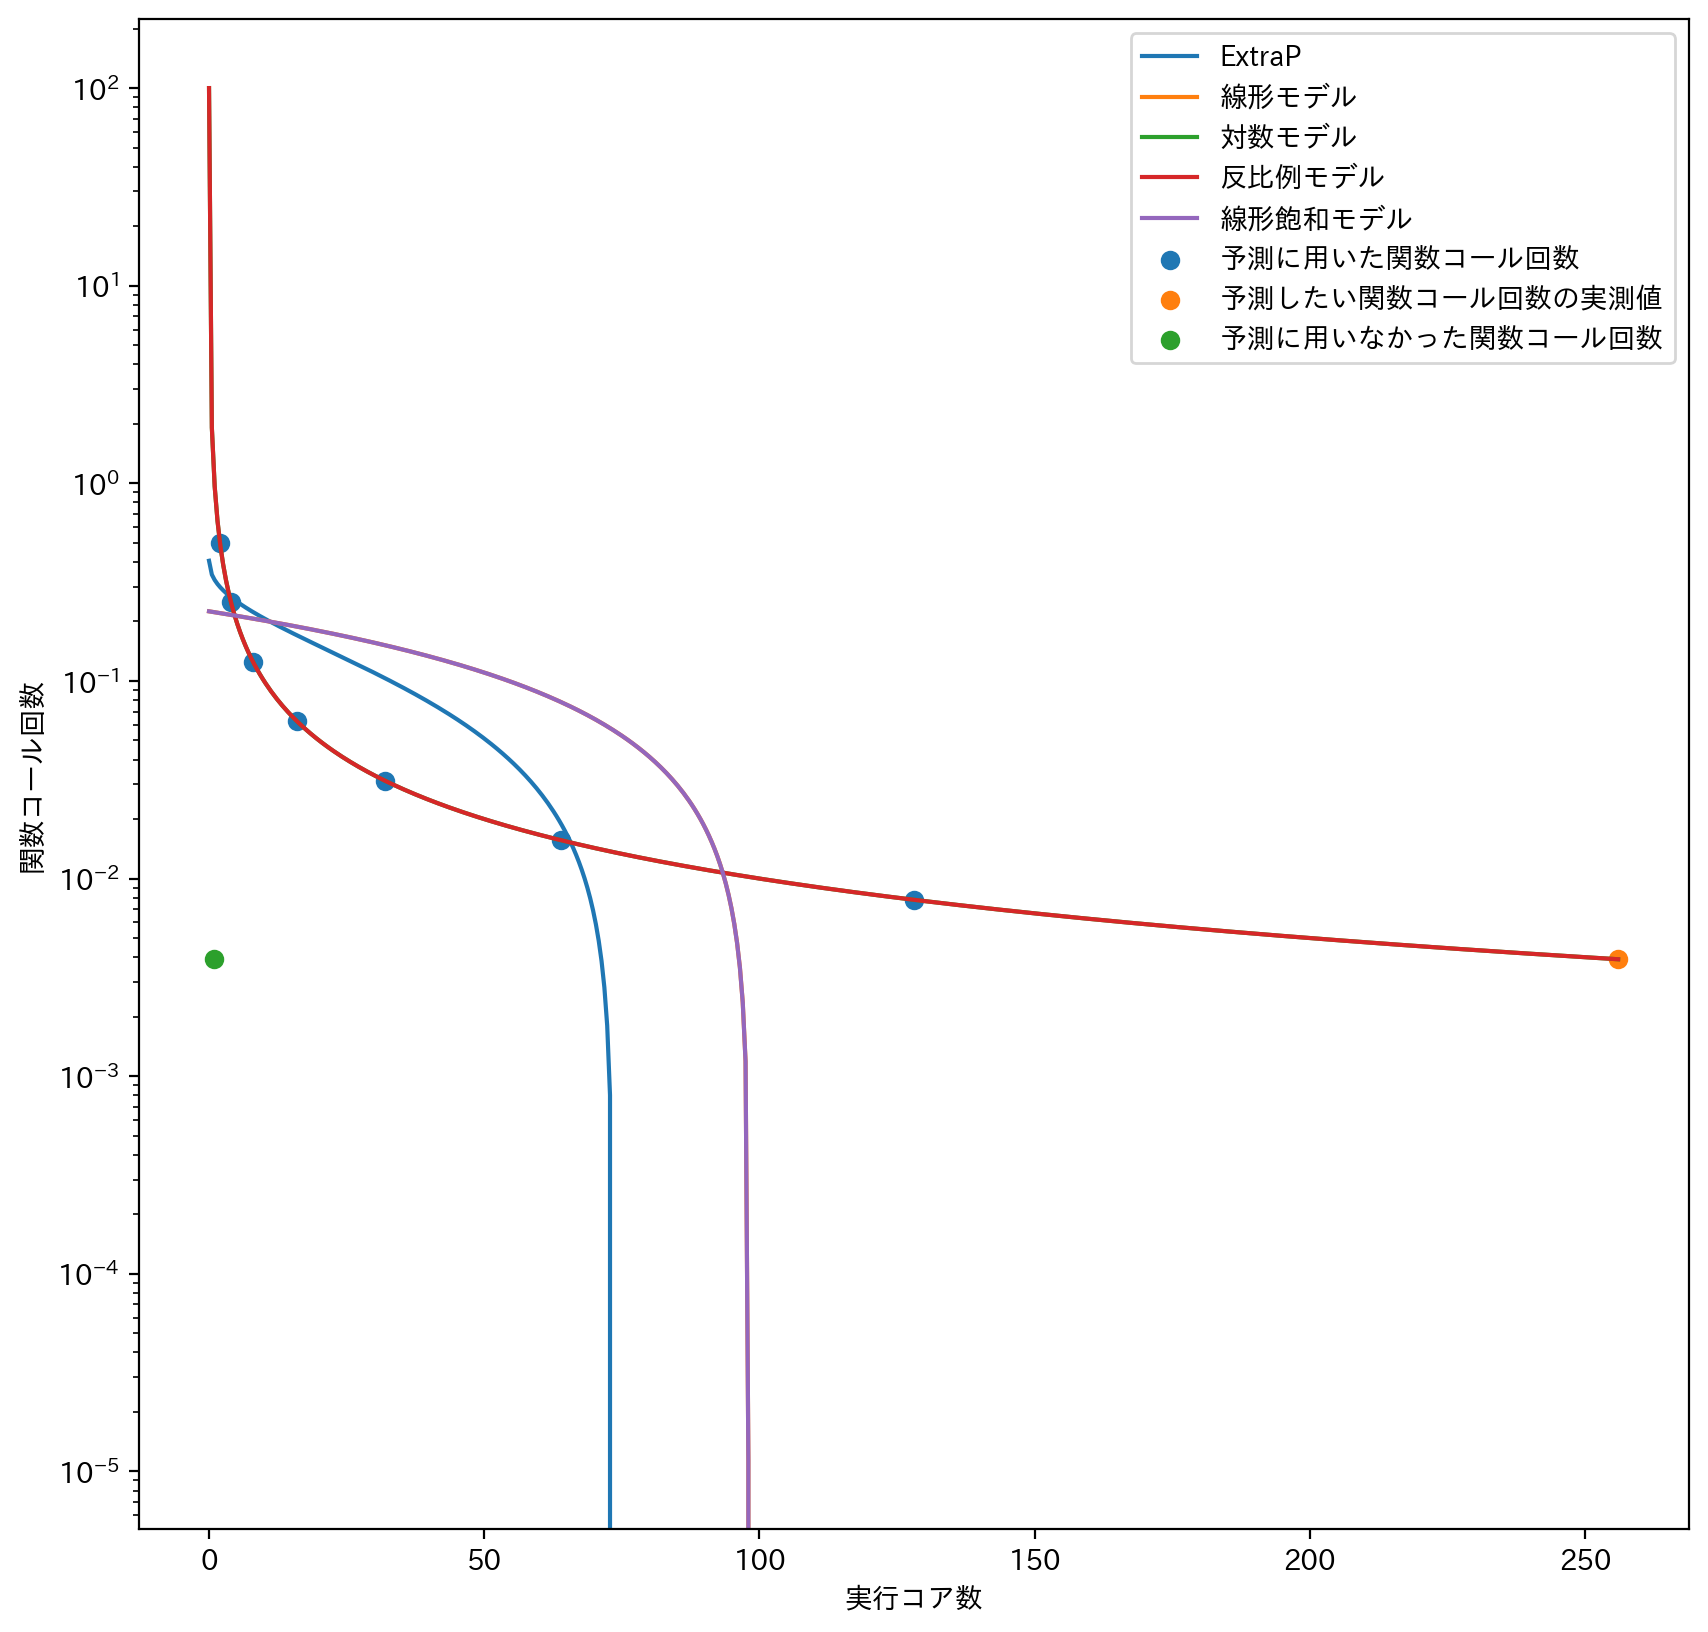

In [5]:
plt.figure(figsize=(10,10),dpi=200)


# ベンチマーク名と関数名の指定
benchmarkName = "ft"
functionName = "SET_CLASS"
print(f"___________________\"{benchmarkName}\"_____\"{functionName}\"___________________")

# 実データの取り出し
functionDF = funcCallNumDict[benchmarkName][functionName]
functionDF
raw_x = functionDF.columns.tolist()
raw_y = [functionDF.at[functionName, x] for x in raw_x]

# Extra-P用の入力データの作成
generateInputFileForExtraPfromLists(input_x=raw_x, input_y=raw_y, repeated=3, includeFirstData=False, includeLastData=False, fileName =f"tmp_{benchmarkName}_{functionName}.txt")
raw_x = np.array(raw_x).reshape(-1,1)
raw_y = np.array(raw_y).reshape(-1, 1)
# Extra-PでfixProcessデータを入力して出力したモデルの図示
plot_x = np.linspace(0.01, 256, 500)
# 下記はExtra-Pで出力されたモデル
# 0.4275975131538263 + -0.10218725390633487 * p^(1/3)
plot_y = []
plot_y = [0.4275975131538263 + -0.10218725390633487 * x**(1/3) for x in plot_x]
plt.plot(plot_x, plot_y, label="ExtraP")

# 説明変数と目的変数に分割
notTrain_x, train_x, target_x = raw_x[0], raw_x[1:-1], raw_x[-1]
notTrain_y, train_y, target_y = raw_y[0], raw_y[1:-1], raw_y[-1]

plt.scatter(train_x, train_y, marker="o", label="予測に用いた関数コール回数")
plt.scatter(target_x, target_y, marker="o", label="予測したい関数コール回数の実測値")
plt.scatter(notTrain_x, notTrain_y, marker="o", label="予測に用いなかった関数コール回数")

# モデル式をプロットするために変数”plot_x”に対して変換を実施
plot_x = np.array(plot_x).reshape(-1, 1)

# 線形モデル
model_lin = ModelLin(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_lin.calc_lr()
plot_y_lin = model_lin.predict(plot_x)
plt.plot(plot_x, plot_y_lin, label="線形モデル")
# 対数モデル
model_log10 = ModelLog10(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_log10.calc_lr()
plot_y_log10 = model_log10.predict(plot_x)
plt.plot(plot_x, plot_y_log10, label="対数モデル")
# 反比例モデル
model_ip = ModelIP(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_ip.calc_lr()
plot_y_ip = model_ip.predict(plot_x)
plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# 線形飽和モデル
model_branch = ModelBranch(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_branch.calc_lr()
plot_y_branch = model_branch.predict(plot_x)
plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("実行コア数")
# 軸の対数軸化
# plt.xscale('log')
plt.yscale('log')

___________________"is"_____"MPI_Irecv()"___________________


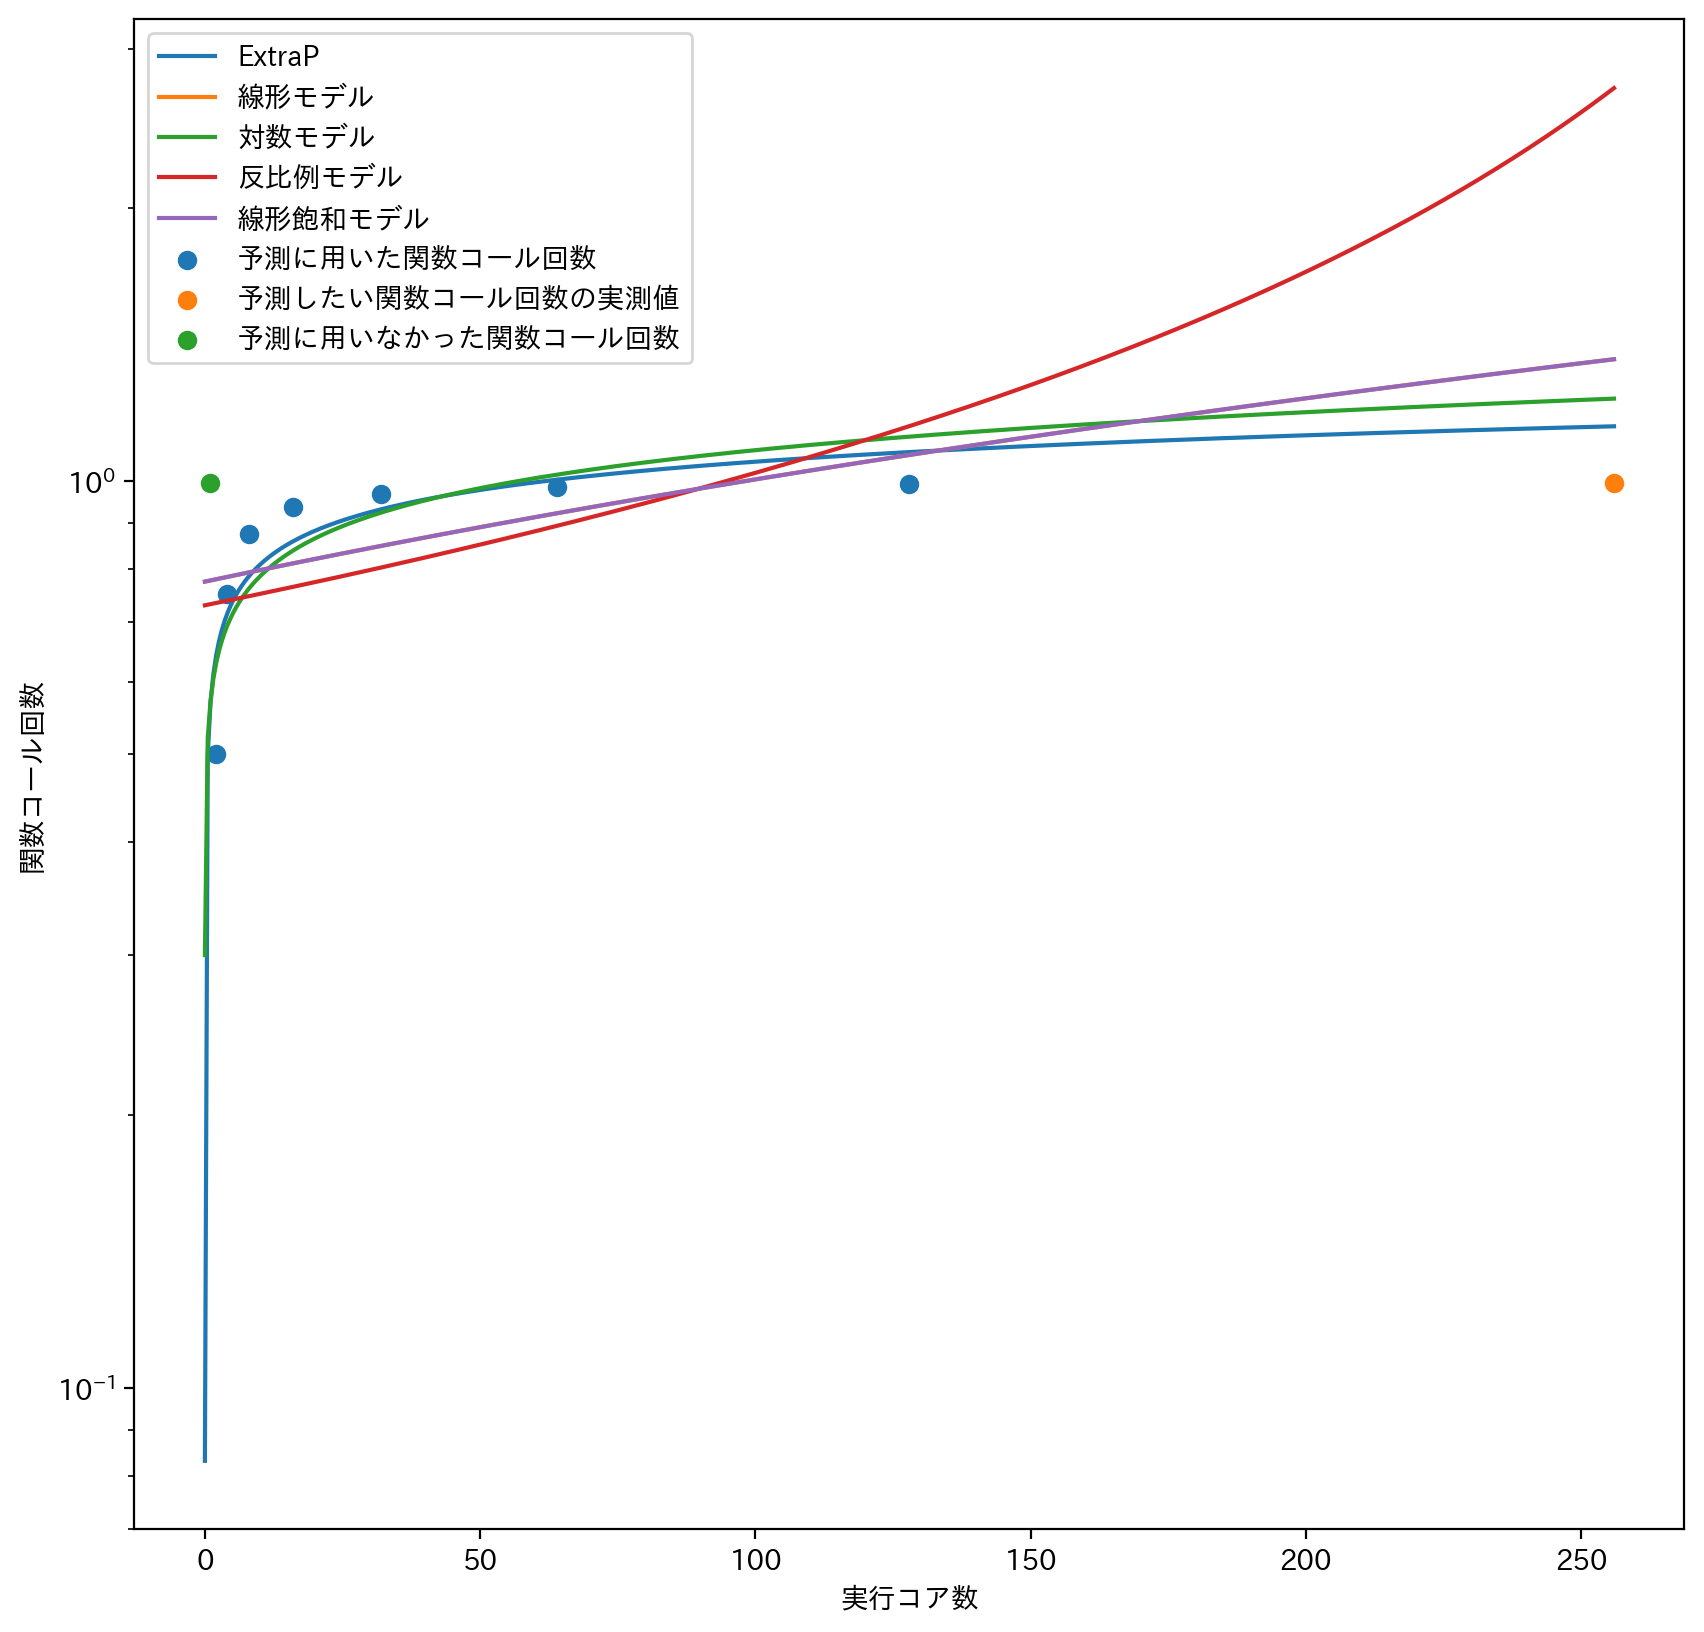

In [6]:
plt.figure(figsize=(10,10),dpi=200)


# ベンチマーク名と関数名の指定
benchmarkName = "is"
functionName = "MPI_Irecv()"
print(f"___________________\"{benchmarkName}\"_____\"{functionName}\"___________________")

# 実データの取り出し
functionDF = funcCallNumDict[benchmarkName][functionName]
functionDF
raw_x = functionDF.columns.tolist()
raw_y = [functionDF.at[functionName, x] for x in raw_x]

# Extra-P用の入力データの作成
generateInputFileForExtraPfromLists(input_x=raw_x, input_y=raw_y, repeated=3, includeFirstData=False, includeLastData=False, fileName =f"tmp_{benchmarkName}_{functionName}.txt")
raw_x = np.array(raw_x).reshape(-1,1)
raw_y = np.array(raw_y).reshape(-1, 1)
# Extra-PでfixProcessデータを入力して出力したモデルの図示
plot_x = np.linspace(0.01, 256, 500)
# 下記はExtra-Pで出力されたモデル
#  0.5669641428571426 + 0.07282371428571434 * log2(p)^(1)
plot_y = []
plot_y = [ 0.5669641428571426 + 0.07282371428571434 * math.log2(x)**(1) for x in plot_x]
plt.plot(plot_x, plot_y, label="ExtraP")

# 説明変数と目的変数に分割
notTrain_x, train_x, target_x = raw_x[0], raw_x[1:-1], raw_x[-1]
notTrain_y, train_y, target_y = raw_y[0], raw_y[1:-1], raw_y[-1]

plt.scatter(train_x, train_y, marker="o", label="予測に用いた関数コール回数")
plt.scatter(target_x, target_y, marker="o", label="予測したい関数コール回数の実測値")
plt.scatter(notTrain_x, notTrain_y, marker="o", label="予測に用いなかった関数コール回数")

# モデル式をプロットするために変数”plot_x”に対して変換を実施
plot_x = np.array(plot_x).reshape(-1, 1)

# 線形モデル
model_lin = ModelLin(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_lin.calc_lr()
plot_y_lin = model_lin.predict(plot_x)
plt.plot(plot_x, plot_y_lin, label="線形モデル")
# 対数モデル
model_log10 = ModelLog10(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_log10.calc_lr()
plot_y_log10 = model_log10.predict(plot_x)
plt.plot(plot_x, plot_y_log10, label="対数モデル")
# 反比例モデル
model_ip = ModelIP(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_ip.calc_lr()
plot_y_ip = model_ip.predict(plot_x)
plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# 線形飽和モデル
model_branch = ModelBranch(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_branch.calc_lr()
plot_y_branch = model_branch.predict(plot_x)
plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("実行コア数")
# 軸の対数軸化
# plt.xscale('log')
plt.yscale('log')

___________________"is"_____"double_randlc(double_*_double_*)"___________________


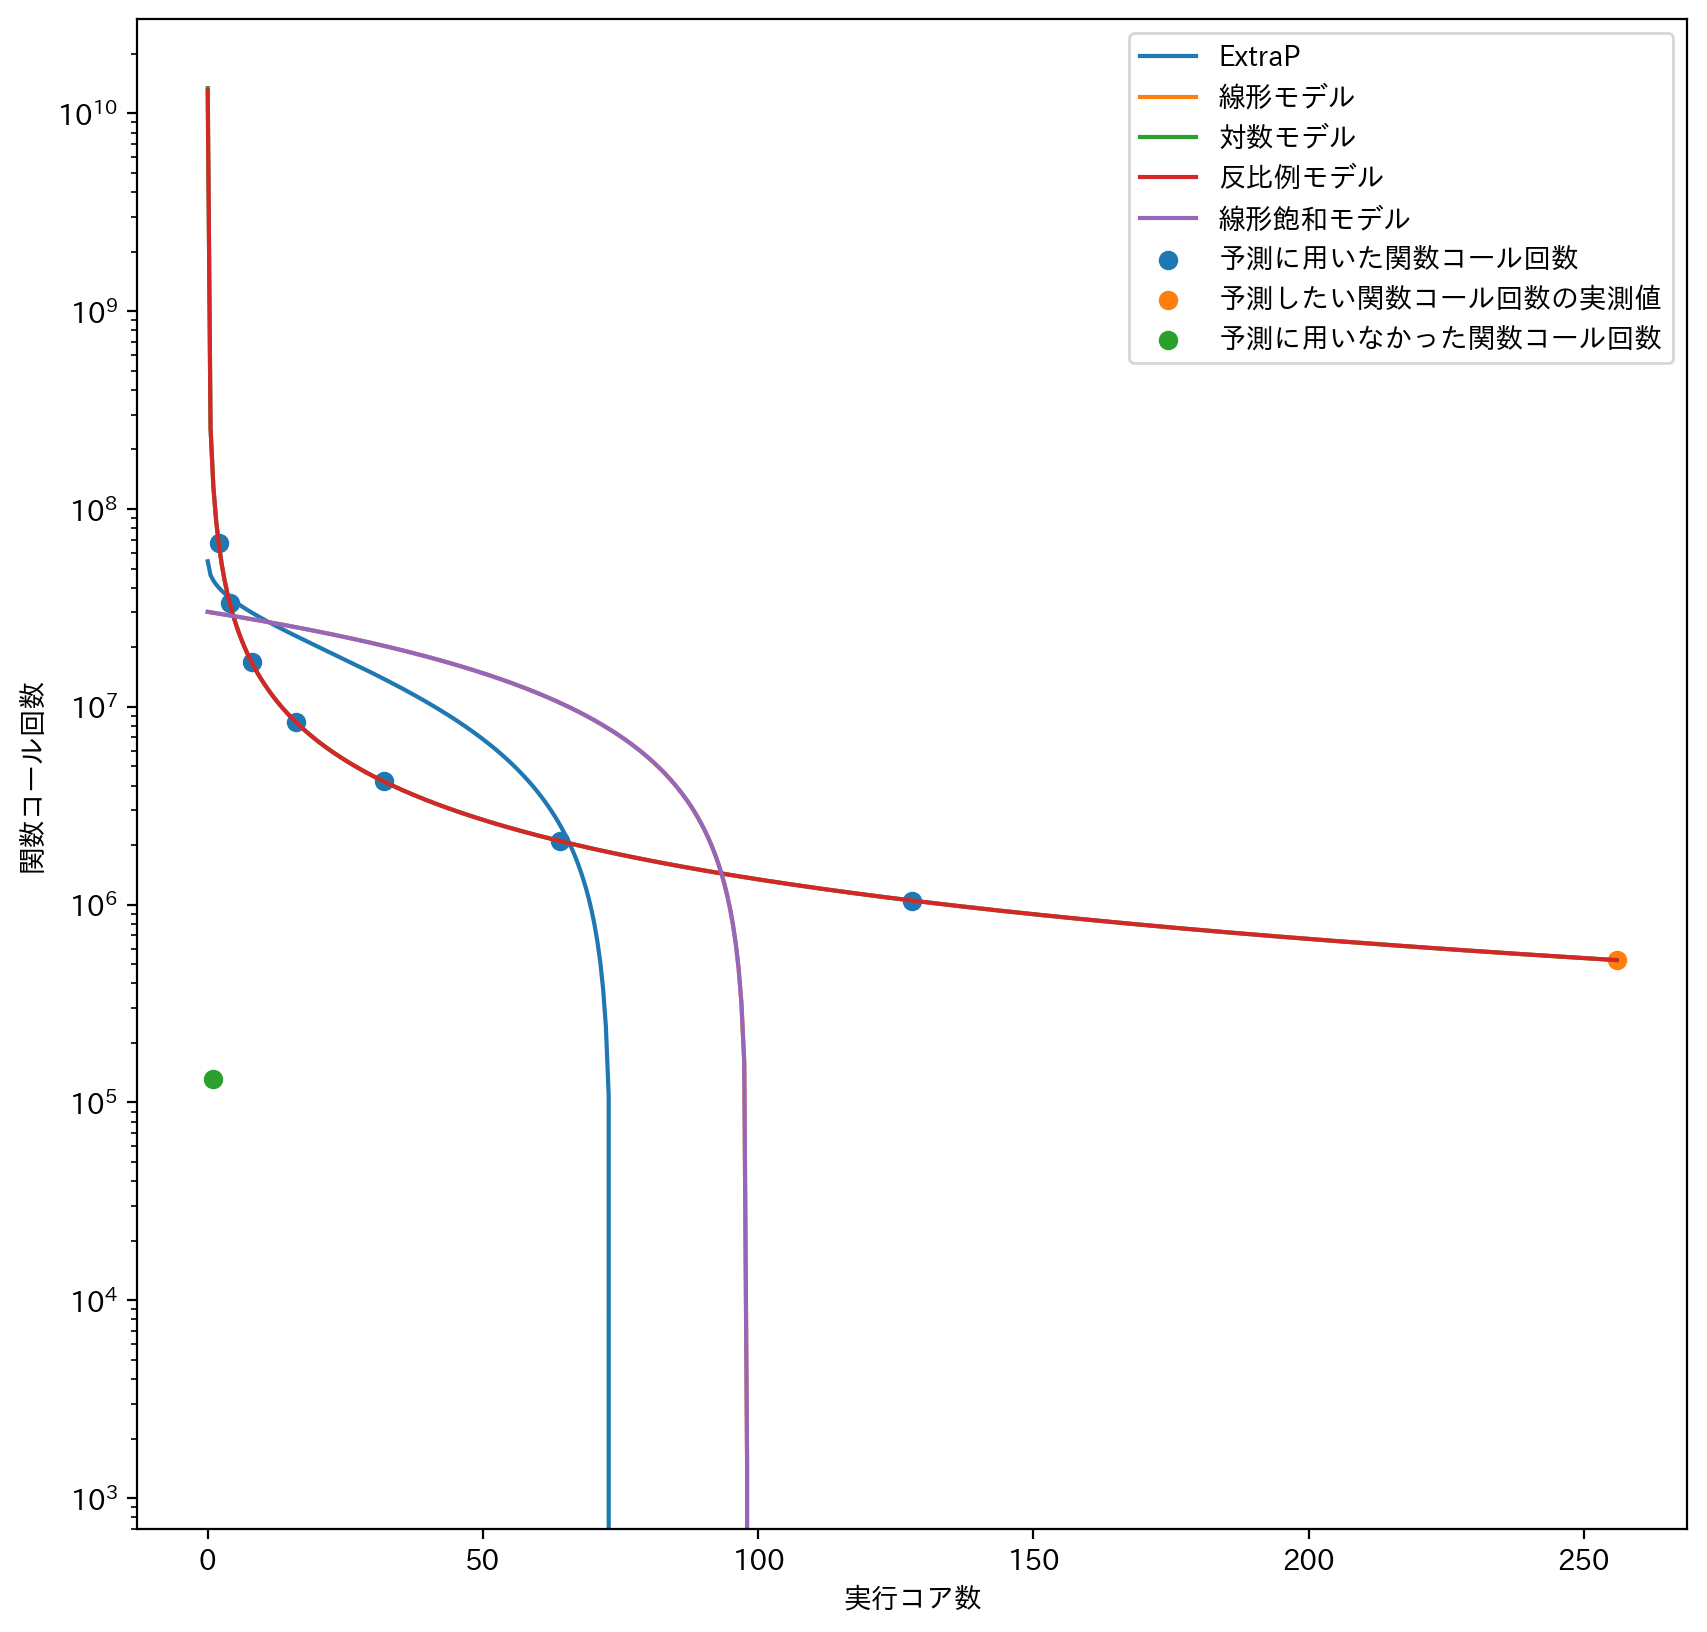

In [7]:
plt.figure(figsize=(10,10),dpi=200)


# ベンチマーク名と関数名の指定
benchmarkName = "is"
functionName = "double_randlc(double_*_double_*)"
print(f"___________________\"{benchmarkName}\"_____\"{functionName}\"___________________")

# 実データの取り出し
functionDF = funcCallNumDict[benchmarkName][functionName]
functionDF
raw_x = functionDF.columns.tolist()
raw_y = [functionDF.at[functionName, x] for x in raw_x]

# Extra-P用の入力データの作成
generateInputFileForExtraPfromLists(input_x=raw_x, input_y=raw_y, repeated=3, includeFirstData=False, includeLastData=False, fileName =f"tmp_{benchmarkName}_{functionName}.txt")
raw_x = np.array(raw_x).reshape(-1,1)
raw_y = np.array(raw_y).reshape(-1, 1)
# Extra-PでfixProcessデータを入力して出力したモデルの図示
plot_x = np.linspace(0.01, 256, 500)
# 下記はExtra-Pで出力されたモデル
# 57391204.1380261 + -13715344.316623986 * p^(1/3)
plot_y = []
plot_y = [57391204.1380261 + -13715344.316623986 * x**(1/3) for x in plot_x]
plt.plot(plot_x, plot_y, label="ExtraP")

# 説明変数と目的変数に分割
notTrain_x, train_x, target_x = raw_x[0], raw_x[1:-1], raw_x[-1]
notTrain_y, train_y, target_y = raw_y[0], raw_y[1:-1], raw_y[-1]

plt.scatter(train_x, train_y, marker="o", label="予測に用いた関数コール回数")
plt.scatter(target_x, target_y, marker="o", label="予測したい関数コール回数の実測値")
plt.scatter(notTrain_x, notTrain_y, marker="o", label="予測に用いなかった関数コール回数")

# モデル式をプロットするために変数”plot_x”に対して変換を実施
plot_x = np.array(plot_x).reshape(-1, 1)

# 線形モデル
model_lin = ModelLin(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_lin.calc_lr()
plot_y_lin = model_lin.predict(plot_x)
plt.plot(plot_x, plot_y_lin, label="線形モデル")
# 対数モデル
model_log10 = ModelLog10(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_log10.calc_lr()
plot_y_log10 = model_log10.predict(plot_x)
plt.plot(plot_x, plot_y_log10, label="対数モデル")
# 反比例モデル
model_ip = ModelIP(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_ip.calc_lr()
plot_y_ip = model_ip.predict(plot_x)
plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# 線形飽和モデル
model_branch = ModelBranch(train_x, train_y, benchmarkName, functionName, test_ratio=0)
model_branch.calc_lr()
plot_y_branch = model_branch.predict(plot_x)
plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("実行コア数")
# 軸の対数軸化
# plt.xscale('log')
plt.yscale('log')